# Segmentación interactiva con Grafos

Tamaño de la imagen: $256 \times 256$

In [1]:
import networkx as nx
import numpy as np
import copy
import imageio
from matplotlib import pyplot as plt
import math

In [2]:
class IIS:
    def __init__(self, digraph, imageout_size):
        # graph es un networkx.DiGraph con un nodo por pixel de la imagen y arcos dirigidos entre los pixeles vecinos. 
        # Cada arco debe tener un atributo "c" con la capacidad y un atributo "tree" = None.
        self.M = copy.deepcopy(digraph)
        self.S = nx.DiGraph()
        self.T = nx.DiGraph()
        self.M.add_node("s", tree="S")
        self.M.add_node("t", tree="T")
        self.S.add_node("s", active=True)
        self.T.add_node("t", active=True)
        self.imageout = np.zeros(imageout_size) -1
        
        self.stats_ciclos = 0
        self.stats_huerfanos = 0
        self.stats_flujo = 0
        
    def get_nodes_lists(self):
        # Devuelve dos listas. La primera tiene los nodos del árbol S (figura) y la segunda los del
        # árbol T (fondo).
        return list(self.S.nodes), list(self.T.nodes)
    
    def _get_path(self, s_node_name, t_node_name):
        # recibe dos nodos conectados, uno del árbol S y otro del árbol T. Devuelve una lista de tuplas con
        # el camino.
        path = [(s_node_name, t_node_name)]
        # cargar nodos de S
        edge_dest = s_node_name
        predecessors = list(self.S.predecessors(edge_dest))
        while len(predecessors) > 0:
            path = [(predecessors[0], edge_dest)] + path
            edge_dest = predecessors[0]
            predecessors = list(self.S.predecessors(edge_dest))
        # cargar nodos de T
        edge_orig = t_node_name
        predecessors = list(self.T.predecessors(edge_orig))
        while len(predecessors) > 0:
            path = path + [(edge_orig, predecessors[0])]
            edge_orig = predecessors[0]
            predecessors = list(self.T.predecessors(edge_orig))
        return path

    def _explore_tree(self, node_name, tree):
        # Busca en M los vértices conectados (sucesores o predecesores según el árbol)
        # Si los vértices conectados (con capacidad > 0) no pertenecen a ningún árbol, lo cargan en tree. 
        # Si pertenece al otro árbol, se encontró un camino.
        # Si encuentra un camino lo devuelve y termina. Si no, devuelve None. Además devuelve "modified_tree"
        # indicando si cambió algo.
        modified_tree = False
        if tree == "S":
            Tree = self.S
            tree_val = 1
            connected = list(self.M.successors(node_name)) 
        else:
            Tree = self.T
            tree_val = 0
            connected = list(self.M.predecessors(node_name)) 
        
        for conn in connected:
            if tree == "S":
                capacity = self.M.edges[(node_name, conn)]["c"]
            else:
                capacity = self.M.edges[(conn, node_name)]["c"]
            if capacity > 0:
                if self.M.node[conn]["tree"] == None:
                    Tree.add_node(conn, active=True)
                    Tree.add_edge(node_name, conn)
                    self.M.node[conn]["tree"] = tree
                    node_coord = self._node_name_decode(conn)
                    self.imageout[node_coord[0], node_coord[1]] = tree_val
                    modified_tree = True
                elif self.M.node[conn]["tree"] != tree:
                    if conn == connected[-1]:
                        Tree.node[node_name]["active"] = False
                    if tree == "S":
                        path = self._get_path(node_name, conn)
                    else:
                        path = self._get_path(conn, node_name)
                    return modified_tree, path
        Tree.node[node_name]["active"] = False
        return  modified_tree, None
   
    def _growth_tree(self, tree):
        # tree puede valer "S" o "T", es el árbol que se va a axplorar y expandir.
        # Calcula un ciclo de la etapa de crecimiento para el árbol S o para el árbol T.
        # Si encuentra un camino lo devuelve, si no, devuelve None.
        # Busca los vértices activos del árbol y llama la función _explore_tree para cadad uno.
        # Además, devuelve "modified" indicando si hubo algún cambio en los grafos.
        if tree == "S":
            tree_dict = nx.get_node_attributes(self.S, "active")
        else:
            tree_dict = nx.get_node_attributes(self.T, "active")
        tree_nodes = list(tree_dict.keys())
        tree_active = list(enumerate(tree_dict.values()))
        tree_activenodes = [tree_nodes[i[0]] for i in tree_active if i[1]==True]
        modified = False
        for node_name in tree_activenodes:
            modified, path = self._explore_tree(node_name, tree)
            if path != None:
                return modified, path
        return modified, None
        
    def _growth(self):
        # Realiza un ciclo de la etapa de crecimiento para el los arboles S y T.
        # Si encuentra un camino lo devuelve, si no, devuelve None.
        # La condición de corte es que no se modiofiquen los grafos ni se encuentre un camino.
        path = None
        mod_S = True
        mod_T = False
        while path == None and (mod_S or mod_T):
            mod_S, path = self._growth_tree(tree="S")
            if path == None:
                mod_T, path = self._growth_tree(tree="T")
        return path

    def _search_orphan(self, edge):
    # Recibe una tupla con la arista. Desconecta (si es necesario) un vertice del arbol al que pertenece.
    # No es necesario si la arista saturada era la que conectaba los dos arboles. En ese caso devuelve None
    # Si la arista no conectaba una hoja del arbol, se deben desconectar los hijos tambien.
    # Ojo, puede haber mas de una arista saturada, asi que en agun caso puede ser que se encuentren nodos
    # ya desconectados.
    # Devuelve el vértice huérfano (si hay) y el árbol al que pertenece.
        orphan = None
        tree = self.M.node[edge[0]]["tree"]
        if tree == self.M.node[edge[1]]["tree"]:
            if tree == "S":
                orphan = edge[1]
            else:
                orphan = edge[0]
        return orphan, tree
    
    def _set_orphan(self, orphan, tree):
    # Devuelve una lista de huerfanos. El primero es el que se paso como parametro (el mas cercano a la raiz
    # del arbol.
        self.M.node[orphan]["tree"] = None
        node_coord = self._node_name_decode(orphan)
        self.imageout[node_coord[0], node_coord[1]] = -1
        if tree == "S":
            Tree = self.S
        else:
            Tree = self.T
        if Tree.has_node(orphan):
            orphans = [orphan]
            successors = list(Tree.successors(orphan))
            for succ in successors:
                orphans = orphans + self._set_orphan(succ, tree)
            Tree.remove_node(orphan)
            return orphans
        else:
        # Puede pasar cuando más de un arco se satura. El vértice se podría intentar eliminar dos veces.
            return []

    def _augmentation(self, path):
        # etapa de camino. Calcula las capacidades residuales y ajusta las actuales.
        # Devuelve una lista de huérfanos y una lista con los árboles a los que pertenecían los huérfanos.
        # Sin no hay huérfanos, las listas están vacías.
        capacities = [self.M.edges[step]["c"] for step in path]
        mincap = np.array(capacities).min()
        orphans = []
        orph_trees = []
        for step in path:
            capacity = self.M.edges[step]["c"] - mincap
            self.M.edges[step]["c"] = capacity
            self.M.edges[step]["f"] = self.M.edges[step]["f"] + mincap
            if capacity <= 0:
            # Arista saturada. El vertice queda huerfano.
                orphan, tree = self._search_orphan(step)
                if orphan != None:
                    new_orphans = self._set_orphan(orphan, tree)
                    orphans = orphans + new_orphans
                    orph_trees = orph_trees + [tree] * len(new_orphans)
        return orphans, orph_trees, mincap
    
    def _adoption_try(self, orphan, tree):
    # Intenta insertar un huérfano en el arbol "tree". Si es posible, devuelve True.
    # Busca los predecesores (para S) o los sucesores (para T) en M. Para el primero que tenga
    # capacidad > 0 y pertenezca a "tree", inserta el nodo en el árbol correspondiente y actualiza
    # "tree" en M.
        father = None
        if tree == "S":
            Tree = self.S
            tree_value = 1
            connected = list(self.M.predecessors(orphan))
            for conn in connected:
                if self.M.node[conn]["tree"] == tree:
                    if self.M.edges[conn, orphan]["c"] > 0:
                        father = conn
                        break
        elif tree == "T":
            Tree = self.T
            tree_value = 0
            connected = list(self.M.successors(orphan)) 
            for conn in connected:
                if self.M.node[conn]["tree"] == tree:
                    if self.M.edges[orphan, conn]["c"] > 0:
                        father = conn
                        break
        if father != None:
            Tree.add_node(orphan, active=True)
            Tree.add_edge(father, orphan)
            self.M.node[orphan]["tree"] = tree
            node_coord = self._node_name_decode(orphan)
            self.imageout[node_coord[0], node_coord[1]] = tree_value
            return True
        else:
            return False

    def _adoption(self, orphans, orph_trees):
    # Recibe una lista de huérfanos y una lista con los árboles a los que pertenecían los huérfanos.
    # Llama a la función _adoption_try para cada huérfano. Si la adopción no es exitosa, lo guarda en 
    # una lista. Al finalizar, si la lista de no-adoptados no está vacía, intenta de nuevo (Alunas inserciones
    # pueden cambiar la situación).
    # Cuando la lista está vacía o después de un intento la lista no cambió, termina.
        prev_orphans_count = 0
        while len(orphans) > 0 and prev_orphans_count != len(orphans):
            prev_orphans_count = len(orphans)
            not_adopted = []
            not_adopted_trees = []
            for orphan in enumerate(orphans):
                if not self._adoption_try(orphan[1], orph_trees[orphan[0]]):
                    not_adopted = not_adopted + [orphan[1]]
                    not_adopted_trees = not_adopted_trees + [orph_trees[orphan[0]]]
            orphans = not_adopted
            orph_trees = not_adopted_trees

    def fit(self):
        path = []
        while path != None:
            self.stats_ciclos += 1
            path = self._growth()
            if path != None:
                orphans, orph_trees, newflow = self._augmentation(path)
                self.stats_flujo += newflow
                if len(orphans) > 0:
                    self._adoption(orphans, orph_trees)
                    self.stats_huerfanos += len(orphans)
            if self.stats_ciclos % 500 == 0:
                self.show_stats()
        self.show_stats()
        return self.imageout
    
    def show_stats(self):
        print("----------------------")
        print("ciclos: " + str(self.stats_ciclos))
        print("flujo: " + str(self.stats_flujo))
        print("huérfanos: " + str(self.stats_huerfanos))
#        plt.figure(figsize=(7,7))
#        plt.imshow(self.imageout, cmap='gray')
#        plt.show()
#        print("image min: " + str(self.imageout.min()) + " image max: " + str(self.imageout.max()))
        
    def _node_name_decode(self, name):
        sep = name.find("-")
        return (int(name[:sep]), int(name[sep + 1:]))        

In [3]:
def mostrar_semillas(imagenC, im_O, im_B):
    imagenS = np.zeros(imagenC.shape)
    imagenS[:,:,0] = np.maximum(imagenC[:,:,0], im_O*255)
    imagenS[:,:,1] = imagenC[:,:,1]
    imagenS[:,:,2] = np.maximum(imagenC[:,:,2], im_B*255)
    plt.figure(figsize=(7,7))
    plt.imshow(imagenS.astype(int))
    plt.show()

In [4]:
class Im_ISS:
    def __init__(self, image):
    # image es un array de numpy que contiene las intensidades de los pixeles de una imagen en escala de gris.
    # neig (neighborhood) es la vecindad elegida. Puede ser 8 o 4.
        self.image = image
        self.image_O = np.zeros(image.shape) # array binario con las semillas de O en "1"
        self.image_B = np.zeros(image.shape)
        self.image_segments = np.zeros(image.shape)
        self.seeds_O = [] # lista de tuplas con las coordenadas de las semillas de O
        self.seeds_B = [] 
        self.im_std = None
        self.im_histo = None
        self.im_histo_O = None
        self.im_histo_B = None
        
    def create_seeds(self, rseeds_O=[], rseeds_B=[]):
    # rseeds_O y rseeds_B son listas de tuplas con las coordenadas de los ángulos superior izquierdo e
    # inferior derecho de rectángulos que contienen semillas para O y B respectivamente.
        for rec in rseeds_O:
            for idx in range(rec[0][0], rec[1][0] + 1):
                for jdx in range(rec[0][1], rec[1][1] + 1):
                    self.image_O[idx, jdx] = 1
                    self.seeds_O.append((idx, jdx))
        for rec in rseeds_B:
            for idx in range(rec[0][0], rec[1][0] + 1):
                for jdx in range(rec[0][1], rec[1][1] + 1):
                    self.image_B[idx, jdx] = 1
                    self.seeds_B.append((idx, jdx))
                    
        
    def create_graph(self, neig=4, en_nlink_func="Boykov", en_tlink_func="Boykov"):
    # neig (neighborhood) es la vecindad elegida. Puede ser 8 o 4.
        self.IM = nx.DiGraph()
        self.IM.add_node("s", tree="S")
        self.IM.add_node("t", tree="T")
        for idx in range(image.shape[0]):
            for jdx in range(image.shape[1]):
                self.IM.add_node(self._node_name_encode(idx, jdx), tree=None)
        if neig == 4:
            self._create_links(en_tlink_func=en_tlink_func, en_nlink_func=en_nlink_func, 
                               neighborhood="neig4")
        elif neig == 8:
            pass
        self.iis = IIS(self.IM, self.image.shape)        
        
    def get_im_std(self):
        if self.im_std == None:
            self.im_std = self.image.std()
        return self.im_std
    
    def _get_im_histo(self):
        if type(self.im_histo) == type(None):
            immax = self.image.max()
            self.im_histo = np.zeros(immax+1)
            for idx in range(self.image.shape[0]):
                for jdx in range(self.image.shape[1]):
                    self.im_histo[self.image[idx, jdx]] += 1
            self._im_histo = self.im_histo / self.image.size
        return(self.im_histo)
            
    def _get_im_histo_O(self, seeds):
        # seeds debería recibir self.seeds_O
        if type(self.im_histo_O) == type(None):
            h = self._get_im_histo()
            self.im_histo_O = np.zeros(len(h))
            for seed in seeds:
                self.im_histo_O[self.image[seed[0], seed[1]]] += 1
            self.im_histo_O = self.im_histo_O / len(seeds)
            self.im_histo_O = self.im_histo_O + .000000001 * (self.im_histo_O == 0)
        return(self.im_histo_O)

    def _get_im_histo_B(self, seeds):
        # seeds debería recibir self.seeds_B
        if type(self.im_histo_B) == type(None):
            h = self._get_im_histo()
            self.im_histo_B = np.zeros(len(h))
            for seed in seeds:
                self.im_histo_B[self.image[seed[0], seed[1]]] += 1
            self.im_histo_B = self.im_histo_B / len(seeds)
            self.im_histo_B = self.im_histo_B + .000000001 * (self.im_histo_B == 0)
        return(self.im_histo_B)
    
    def _node_name_encode(self, idx, jdx):
        return str(idx) + "-" + str(jdx)

    def _node_name_decode(self, name):
        sep = name.find("-")
        return (int(name[:sep]), int(name[sep + 1:]))
        
    def _energy_nlink_sum(self, idx, jdx, idx_n, jdx_n):
    # devuelve la suma de las intensidades del pixel principal (idx,jdx) y del pixel vecino (idx_n,jdx_n)
        return self.image[idx, jdx] + self.image[idx_n, jdx_n]

    def _energy_nlink_Boykov(self, idx, jdx, idx_n, jdx_n):
    # De Interactive Graph Cuts for Optimal Boundary & Region Segmentation of Objects in N-D Images
    # Yuri Y. Boykov & Marie-Pierre Jolly (2001)        
        dist = ((idx-idx_n)**2 + (jdx-jdx_n)**2 ) ** (1/2)
        energy = math.exp(-((imiss.image[idx, jdx] - imiss.image[idx_n, jdx_n]) ** 2)/
                          (2 * (imiss.get_im_std() ** 2)))
        energy = energy / dist
        return energy
    
    def _energy_tlink_Boykov(self, idx, jdx, terminal):
    # De Interactive Graph Cuts for Optimal Boundary & Region Segmentation of Objects in N-D Images
    # Yuri Y. Boykov & Marie-Pierre Jolly (2001)
        K = 1_000_000
        lambda_cte = 1
        if terminal == "s":
            if self.image_O[idx, jdx] == 1:
                return K
            elif self.image_B[idx, jdx] == 1:
                return 0
            else:
                return lambda_cte * (-1) * np.log(self._get_im_histo_B(self.seeds_B)[self.image[idx, jdx]])
        elif terminal == "t":
            if self.image_O[idx, jdx] == 1:
                return 0
            elif self.image_B[idx, jdx] == 1:
                return K
            else:
                return lambda_cte * (-1) * np.log(self._get_im_histo_O(self.seeds_O)[self.image[idx, jdx]])
        
    def _energy_tlink_sum(self, idx, jdx, terminal, seeds_O, seeds_B):
    # Método inutil para probar. BORRAR!!
        return self.image[idx, jdx] + 10
    
    def _create_nlinks_neig4(self, idx, jdx, function):
    # calcula la energía del pixel (idx, jdx) con respecto a sus 4-vecinos y la carga en el grafo como
    # un arco saliente de (idx, jdx).
        if idx > 0:
            idx_n = idx - 1
            jdx_n = jdx
            self.IM.add_edge(self._node_name_encode(idx, jdx), self._node_name_encode(idx_n, jdx_n), 
                            c=function(idx, jdx, idx_n, jdx_n), f=0)
        if idx < self.image.shape[0]-1:
            idx_n = idx + 1
            jdx_n = jdx
            self.IM.add_edge(self._node_name_encode(idx, jdx), self._node_name_encode(idx_n, jdx_n), 
                            c=function(idx, jdx, idx_n, jdx_n), f=0)
        if jdx > 0:
            idx_n = idx
            jdx_n = jdx - 1
            self.IM.add_edge(self._node_name_encode(idx, jdx), self._node_name_encode(idx_n, jdx_n), 
                            c=function(idx, jdx, idx_n, jdx_n), f=0)
        if jdx < self.image.shape[1]-1:
            idx_n = idx
            jdx_n = jdx + 1
            self.IM.add_edge(self._node_name_encode(idx, jdx), self._node_name_encode(idx_n, jdx_n), 
                            c=function(idx, jdx, idx_n, jdx_n), f=0)
    
    
    def _create_links(self, en_tlink_func, en_nlink_func, neighborhood="neig4"):
        # Recorre la imagen creando n-links y t-links
        # seeds_O u seeds_B son listas con los pixeles elegidos como semillas para Object y Background
        if en_nlink_func == "sum":
            func_nlink = self._energy_nlink_sum
        elif en_nlink_func == "Boykov":
            func_nlink = self._energy_nlink_Boykov
        if en_tlink_func == "sum":
            func_tlink = self._energy_tlink_sum
        elif en_tlink_func == "Boykov":
            func_tlink = self._energy_tlink_Boykov
        for idx in range(self.image.shape[0]):
            for jdx in range(self.image.shape[1]):
                # Crear t-links
                # Crear link a "s"
                self.IM.add_edge("s", self._node_name_encode(idx, jdx), c=func_tlink(idx, jdx, "s"), f=0)             
                # Crear link a "t"
                self.IM.add_edge(self._node_name_encode(idx, jdx), "t", c=func_tlink(idx, jdx, "t"), f=0)             
                
                # Crear n-links
                if neighborhood=="neig4":
                    self._create_nlinks_neig4(idx, jdx, func_nlink)
    
    def fit(self):
        imageout = self.iis.fit()
        return imageout
        
    def get_segmentation(self):
        pass

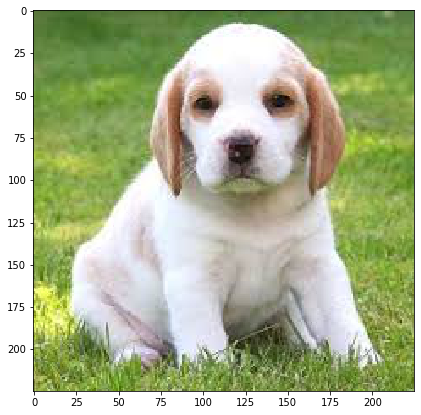

Tamaño de la imagen: (225, 225)
Min: 5
Max: 255


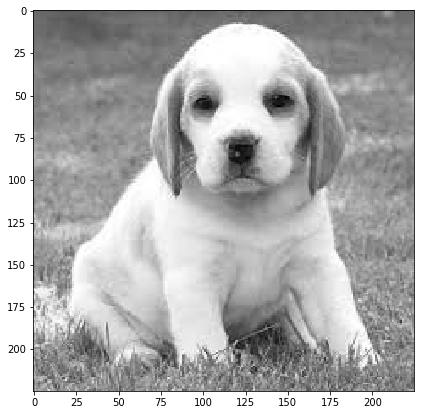

In [10]:
imagen = imageio.imread('perrito2.jpeg')
plt.figure(figsize=(7,7))
plt.imshow(imagen)
plt.show()
coefR = .2125
coefG = .7154
coefB = .0721
R, G, B = imagen[:,:,0],  imagen[:,:,1],  imagen[:,:,2]
imagenG = np.round(coefR * R + coefG * G + coefB * B).astype(int)
print("Tamaño de la imagen: " + str(imagenG.shape))
print("Min: " + str(imagenG.min()))
print("Max: " + str(imagenG.max()))
plt.figure(figsize=(7,7))
plt.imshow(imagenG, cmap='gray')
plt.show()

Crear instancia de Im_ISS...
CPU times: user 741 ms, sys: 120 ms, total: 861 ms
Wall time: 871 ms
Casrgando semillas...
CPU times: user 8.34 ms, sys: 8 µs, total: 8.35 ms
Wall time: 8.51 ms


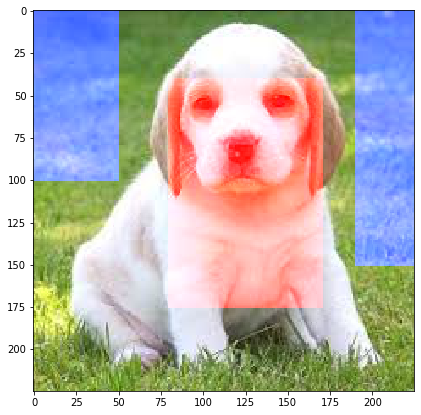

Histogramas de O(rojo) y B(azul):


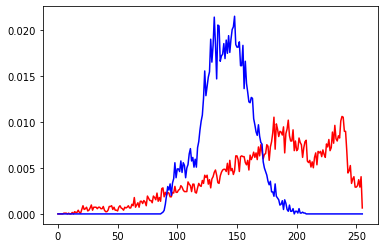

Crear grafo...
CPU times: user 5 s, sys: 128 ms, total: 5.13 s
Wall time: 5.16 s
Segmentar...
----------------------
ciclos: 500
flujo: 2610.8527053371986
huérfanos: 10784
----------------------
ciclos: 1000
flujo: 5113.436788017548
huérfanos: 14338
----------------------
ciclos: 1500
flujo: 7614.298511012325
huérfanos: 18450
----------------------
ciclos: 2000
flujo: 10086.011743563648
huérfanos: 25264
----------------------
ciclos: 2500
flujo: 12689.647820353415
huérfanos: 31383
----------------------
ciclos: 3000
flujo: 15321.026418532872
huérfanos: 40602
----------------------
ciclos: 3500
flujo: 17857.940594428244
huérfanos: 51038
----------------------
ciclos: 4000
flujo: 20446.432907511004
huérfanos: 59605
----------------------
ciclos: 4500
flujo: 22928.368594339114
huérfanos: 71888
----------------------
ciclos: 5000
flujo: 25386.729628550213
huérfanos: 81710
----------------------
ciclos: 5500
flujo: 27772.98119978299
huérfanos: 95434
----------------------
ciclos: 6000
flujo

In [11]:
# Crear instancia de Im_ISS
#image = np.random.randint(0, high=256, size=(640,480))
image = imagenG
print("Crear instancia de Im_ISS...")
%time imiss = Im_ISS(image=image)

# Definir semillas "interactivamente"
rseeds_O = [((40,80),(175,170))]
rseeds_B = [((0,0),(100,50)), ((0,190),(150,224))]
print("Casrgando semillas...")
%time imiss.create_seeds(rseeds_O=rseeds_O, rseeds_B=rseeds_B)
#imagen = imageio.imread('perritos.jpg')
mostrar_semillas(imagen, imiss.image_O, imiss.image_B)

# Comparar histogramas de O y B
print("Histogramas de O(rojo) y B(azul):")
plt.plot(imiss._get_im_histo_O(imiss.seeds_O), color="r")
plt.plot(imiss._get_im_histo_B(imiss.seeds_B), color="b")
plt.show()

# Crear grafo
print("Crear grafo...")
%time imiss.create_graph()

# Segmentar
print("Segmentar...")
%time A = imiss.fit()



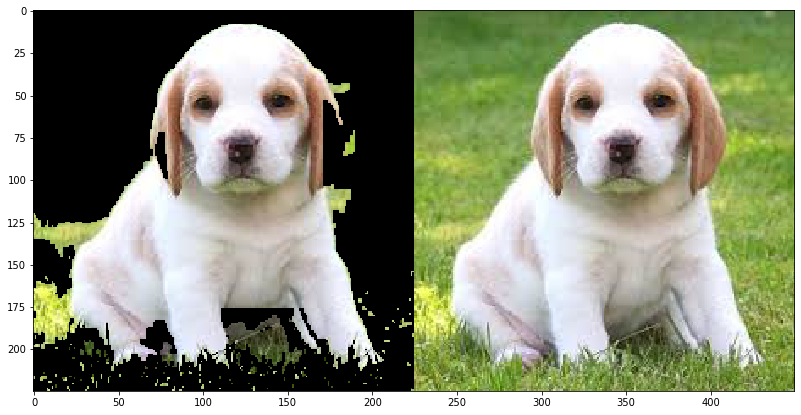

In [12]:
imagenS = np.zeros(imagen.shape)
mascara = A == np.ones(A.shape)
imagenS[:,:,0] = imagen[:,:,0] * mascara
imagenS[:,:,1] = imagen[:,:,1] * mascara
imagenS[:,:,2] = imagen[:,:,2] * mascara
plt.figure(figsize=(14,7))
imagenS = imagenS.astype(int)
plt.imshow(np.hstack((imagenS, imagen)))
plt.show()

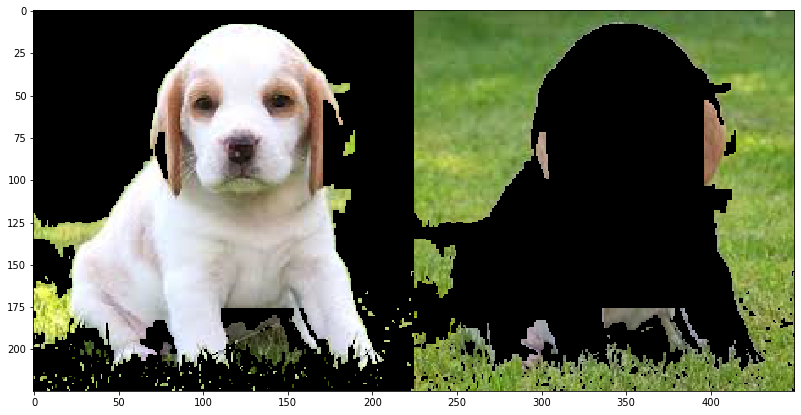

In [13]:
imagenO = np.zeros(imagen.shape)
mascara = A == np.ones(A.shape)
imagenO[:,:,0] = imagen[:,:,0] * mascara
imagenO[:,:,1] = imagen[:,:,1] * mascara
imagenO[:,:,2] = imagen[:,:,2] * mascara
imagenO = imagenO.astype(int)

imagenB = np.ones(imagen.shape)
mascara = np.logical_not(mascara )
imagenB[:,:,0] = imagen[:,:,0] * mascara
imagenB[:,:,1] = imagen[:,:,1] * mascara
imagenB[:,:,2] = imagen[:,:,2] * mascara
imagenB = imagenB.astype(int)

plt.figure(figsize=(14,7))
plt.imshow(np.hstack((imagenO, imagenB)))
plt.show()